<a href="https://colab.research.google.com/github/bozorgpanah/The-Explainable-Machine-Learning-Model-withPrivacy/blob/main/Paper1/MDAV%2BSHAP_USAHousing_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Uploading a dataset from local drive to colab
from google.colab import files
uploaded = files.upload()

Saving USA_Housing.csv to USA_Housing (9).csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import io

##Reading dataset
df = pd.read_csv(io.BytesIO(uploaded['USA_Housing.csv'])) #Dataset's name == housing.csv
# Dataset is now stored in a Pandas Dataframe
df.info()


# now check for missing values in total bedrooms
df.isnull().sum()
# ------------------------------------------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64

In [ ]:
##Feature Vector and Target Variable
X = df[['Avg. Area Income','Avg. Area House Age','Avg. Area Number of Rooms','Avg. Area Number of Bedrooms', 'Area Population','Price']] #Feature Vector
y = df['Price'] #Target Variable

##Splitting the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train,y_train)
print("####################################################################################################")
print(X_test,y_test)

      Avg. Area Income  Avg. Area House Age  ...  Area Population         Price
2858       77947.46436             6.441789  ...      29660.79658  1.539129e+06
1559       69931.40110             6.099507  ...      52079.18818  1.389287e+06
1441       65841.30879             5.587065  ...      48253.27664  1.029862e+06
2179       73682.48621             4.611184  ...      34366.18010  7.660784e+05
1390       72813.80169             8.543764  ...      35014.84821  1.727007e+06
...                ...                  ...  ...              ...           ...
4931       77622.95812             6.738014  ...      51102.44195  1.599997e+06
3264       80051.84712             5.872678  ...      35254.12832  1.354609e+06
1653       67094.19707             5.346437  ...      30022.53717  1.202993e+06
2607       52541.31985             4.885243  ...      41258.26229  8.429859e+05
2732       86762.88286             6.530193  ...      47724.58136  1.571254e+06

[3500 rows x 6 columns] 2858    1.53912

In [ ]:
#MDAV a microagregation method 
def dist(x,y):
    return np.linalg.norm(x-y)
    
#Stack arrays in sequence vertically (row wise)
def poprow(arr,i):
    pop = arr[i]
    new_array = np.vstack((arr[:i],arr[i+1:]))
    return new_array,pop

def cluster(X, p, k, dist_to_xr):
    c = [p]
    
    if dist_to_xr == None:
        distances = [dist(v[:-1],p[:-1]) for v in X]
    else:
        distances = dist_to_xr
        
    X = X[np.argpartition(distances, k-1)]
    c.extend(X[:k-1])
    X = X[k-1:]
    
    xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    yc = np.array([p[-1] for p in c], copy=False)
    cl = (xc, yc)
    
    return X, cl

def mdav(X, y, k):
    D = np.column_stack((X,y)) #D is a matrix of variables
    clusters = []
    centroids = []
    while len(D) >= 3*k:
        # Centroid
        xm = np.mean(D, axis=0) #xm is an array includes mean in each variables (each columns)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])#Find furthest from the centroid in each vector and it's called xri
        D, xr = poprow(D, xri)
        # Furthest from furthest from centroid
        dist_to_xr = [dist(v[:-1],xr[:-1]) for v in D]
        xsi = np.argmax(dist_to_xr)
        dist_to_xr = dist_to_xr[:xsi]+dist_to_xr[xsi+1:]
        D, xs = poprow(D, xsi) 

        #cluster of xr
        D, c = cluster(D, xr, k, dist_to_xr)
        clusters.append(c)
        #cluster of xs
        D, c = cluster(D, xs, k, None)
        clusters.append(c)
        
    if len(D) >= 2*k and len(D) < 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        #cluster of xr
        D, c = cluster(D, xr, k, None)
        clusters.append(c)
        
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)     
    else:
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)
    
    centroids = np.array([np.mean(c[0],axis=0) for c in clusters], copy=False)
    
    return clusters, centroids

In [ ]:
#We use smaller K amount
import csv
import time
import statistics 
exec_times = []

# Generate clusters for different representativities
#representativity = [0.001,0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 
#                    0.009, 0.01, 0.02, 0.03]
"""
representativity = [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1]

K = [int(len(X)*r) for r in representativity]#K = [int(len(X_train)*r) for r in representativity]
"""
K = 357
i = 0
k = int(5000/K)
clusterings = []
centroids = []
maskedData = []
print(f'k = {k}')

 #for k in K:
start = time.time()
    #print(k, K)
clustering, centroid = mdav(X, y, k)#clustering, centroid = mdav(X_train, y_train, k)
clusterings.append(clustering)
centroids.append(centroid)


with open('clusterings_csv.csv','w',newline='') as fp:
   c = csv.writer(fp, delimiter = ',')    
   for line in clusterings:
    c.writerows(line)
################################################################################
j=0
with open('centroids_csv.csv','w',newline='') as f:
    fieldnames = ['Avg. Area Income','Avg. Area House Age','Avg. Area Number of Rooms','Avg. Area Number of Bedrooms', 'Area Population','Price']
    z = csv.DictWriter(f, fieldnames=fieldnames)
    z.writeheader()
    z = csv.writer(f, delimiter = ',')
    for line in centroids:
      for j in range(0,k):
        z.writerows(line)

i = 0
while i<k:
 maskedData.append(centroid) 
 i += 1  

end = time.time()
exec_times.append(end-start)
    #arr_ctr_num.append(len(centroids))
print(f'Time for calculating = {exec_times}')

#Saveing centroids in a file
f_centroids = open("Centroids.txt","wt")
f_centroids.write("\n"+str(centroids)+"\n")
f_clusters = open("Clusers.txt","wt")
f_clusters.write("\n"+str(clusterings)+"\n")
f_maskedData = open("MaskedData.txt","wt")
f_maskedData.write("\n"+str(maskedData)+"\n")
f_maskedData.close()
f_centroids.close()
f_clusters.close()
#files.download("clusterings_csv.csv")
files.download("centroids_csv.csv")

k = 14
Time for calculating = [10.493773221969604]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#SHAP
!pip install shap #Install SHAP library
#Uploading a dataset from local drive to colab
from google.colab import files
uploaded = files.upload()

Saving centroids_csv (ProtectedDataset)k=7.csv to centroids_csv (ProtectedDataset)k=7 (1).csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import io

##Reading dataset
df = pd.read_csv(io.BytesIO(uploaded['centroids_csv (ProtectedDataset)k=7.csv'])) #Dataset's name == housing.csv OR == centroids_csv (ProtectedDataset)K=10
# Dataset is now stored in a Pandas Dataframe
df.info()

# now check for missing values in total bedrooms
df.isnull().sum()
# ------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              4998 non-null   float64
 1   Avg. Area House Age           4998 non-null   float64
 2   Avg. Area Number of Rooms     4998 non-null   float64
 3   Avg. Area Number of Bedrooms  4998 non-null   float64
 4   Area Population               4998 non-null   float64
 5   Price                         4998 non-null   float64
dtypes: float64(6)
memory usage: 234.4 KB


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
dtype: int64

In [ ]:
import math
##Feature Vector and Target Variable
X = df[['Avg. Area Income','Avg. Area House Age','Avg. Area Number of Rooms','Avg. Area Number of Bedrooms', 'Area Population']] #Feature Vector
y = df['Price'] #Target Variable

##Splitting the data into train and test data
from sklearn.model_selection import train_test_split
X_masked_train, X_masked_test, y_masked_train, y_masked_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

"""
print(X_train,y_train)
print("####################################################################################################")
print(X_test,y_test)
"""
##Building the model with --> Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_masked_train, y_masked_train)

##Generating Predictions
y_pred = model.predict(X_masked_test)
print("Prediction: ", y_pred)

##Evaluating Performance
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_masked_test, y_pred)**(0.5)
print("mean_squared_error: ", mse)

rmse = math.sqrt(mse)
print('\n\nAccuracy for Random Forest:',100*max(0,rmse)) 



Prediction:  [1468304.37398393  932589.53731957 1135713.57692728 ...  476534.87226017
  754865.26442412 1247353.30135667]
mean_squared_error:  72510.47129433352


Accuracy for Random Forest: 26927.768436009235


In [ ]:
##SHAP Explanation
#Force Plots
# import shap library
import shap 
from IPython.display import display

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:]))


In [ ]:
##SHAP Feature Importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

##SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

##SHAP Dependence Plot
shap.dependence_plot('Avg. Area Income', shap_values, X_train)
shap.dependence_plot('Avg. Area House Age', shap_values, X_train)
shap.dependence_plot('Avg. Area Number of Rooms', shap_values, X_train)
shap.dependence_plot('Avg. Area Number of Bedrooms', shap_values, X_train)
shap.dependence_plot('Area Population', shap_values, X_train)


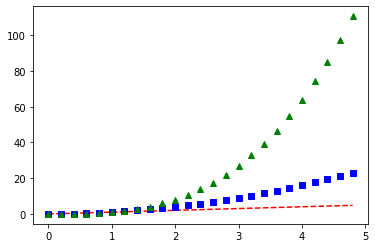

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

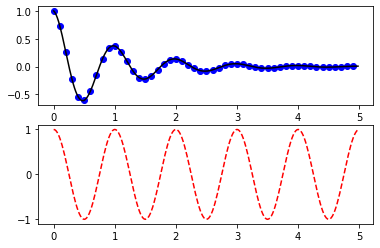

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()

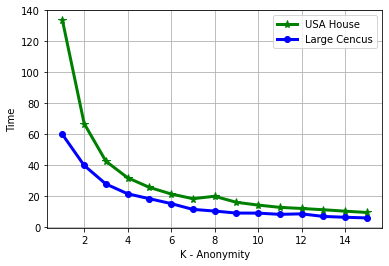

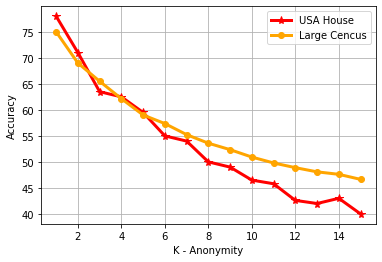

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


k = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

#USA_Housing

#mean_squared_error_USAHouse = [152516.4183, 125787.9283, 100910.2065, 97869.09366, 88332.265, 74837.05189, 72510.47129, 63132.0167660284, 60806.4999760259, 54244.4975516425, 52656.0790632044, 45554.5338454061, 44698.1781886095, 48385.66428200864, 41330.8500044522]

time_complexity_USAHouse = [133.6854165, 67.02958226, 42.72676253, 32.04197598, 25.84488916, 21.59089136, 18.55359197, 20.0995290279388, 16.2225556373596, 14.4218640327453, 12.9547564983367, 12.2288794517517, 11.419191122055, 10.4937732219696, 9.65823173522949]

Accuracy_USAHouse = [78, 71, 63.5, 62.5, 59.5, 55, 54, 50, 49, 46.5, 45.8, 42.6, 42, 43, 40]##
#################################################################################

#large_Cencus
#mean_squared_error_LargeCencus = [,, 0.428978227, 0.386254236, 0.34828286, 0.329077131, 0.305161417, 0.287220948, 0.274083969, 0.259383635, 0.24796962, 0.239052984, 0.231227924, 0.226690078, 0.217538907]
time_complexity_LargeCencus = [60.000, 40.000, 28.01935515, 21.703, 18.545, 15.38548301, 11.64112597, 10.57306439, 9.267805222, 9.23732843, 8.43850508, 8.758252225, 7.10372804, 6.566324381, 6.138981] ##
Accuracy_LargeCencus = [75, 69, 65.49642944, 62.14935529, 59.01549457, 57.36561634, 55.2414172, 53.59299841, 52.35302939, 50.92971974, 49.79654805, 48.89304492, 48.08616479, 47.6119815, 46.64106638]


t1 = np.arange(0.0, 15.0, 0.02)




#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])

plt.plot(k, time_complexity_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House") 
plt.plot(k, time_complexity_LargeCencus, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Large Cencus")
plt.xlabel('K - Anonymity')
plt.ylabel('Time')
#plt.title('Time Complexity')
plt.grid()
plt.legend()
plt.show()




plt.plot(k, Accuracy_USAHouse, color='red', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='red', markersize=8, label = "USA House") 
plt.plot(k, Accuracy_LargeCencus, color='orange', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='orange', markersize=6, label = "Large Cencus")
plt.xlabel('K - Anonymity')
plt.ylabel('Accuracy')
#plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()


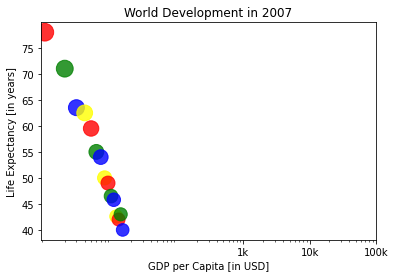

In [ ]:
# Import numpy as np
import numpy as np

# Store pop as a numpy array: np_pop
Accuracy_USAHouse = [78, 71, 63.5, 62.5, 59.5, 55, 54, 50, 49, 46.5, 45.8, 42.6, 42, 43, 40]##
k = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
np_pop = np.array(Accuracy_USAHouse)
col = ['red', 'green', 'blue', 'yellow', 'red', 'green', 'blue', 'yellow', 'red', 'green', 'blue', 'yellow','red', 'green', 'blue']
# Double np_pop
np_pop = np_pop * 2

# Specify c and alpha inside plt.scatter()
plt.scatter(x = k, y = Accuracy_USAHouse, s = np.array(np_pop) * 2, c = col, alpha = 0.8)

# Previous customizations
plt.xscale('log') 
plt.xlabel('GDP per Capita [in USD]')
plt.ylabel('Life Expectancy [in years]')
plt.title('World Development in 2007')
plt.xticks([1000,10000,100000], ['1k','10k','100k'])

# Show the plot
plt.show()



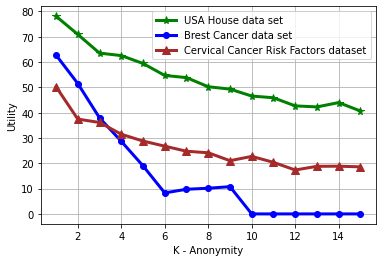

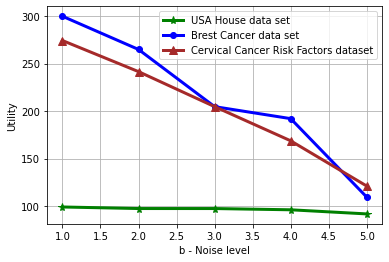

In [ ]:
#Utility
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
acc_k_USAHouse = [78.10670096,70.9331878, 63.53273378, 62.5680729, 59.44148888, 54.71272316, 53.85553688,  
                  50.2521708, 49.31794804, 46.58089632, 45.89382488,42.68701622, 42.28388732, 43.99348328, 40.65998032] #79.7680372563868,
acc_k_brestCancer = [62.7600016466571, 51.5220825866521, 37.9600931189952, 28.6913856598952, 18.9987137593823, 8.30701847025929,
                     9.74101171157336, 10.1395162657666, 10.7727327376636, 1.18053119022442E-06, 0.0000013464719110874, 1.29801594672482E-06,
                     1.53464611165755E-06, 1.21443198875691E-06, 9.65802212736731E-07] #65.4435343623855, 
acc_k_cernivalCancer= [50.2572852340675, 37.4649566384344, 36.1282772023168, 31.4921660939984, 28.7836585416053,
                       26.7728302424121, 24.7620783279058, 24.1628989198529, 21.0291004776595, 22.7283441236621, 20.3848075661027,
                       17.3478270236193, 18.80971323174, 18.8567812568789, 18.595960026054] #48.178427651292, 



plt.plot(k, acc_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(k, acc_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, acc_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('Utility') #Accuracy
#plt.title('Utility')
plt.grid()
plt.legend()
plt.show()

#################################################################################  b

acc_b_USAHouse = [99.01, 97.3720155460385, 97.3598693259741, 96.0494239696362, 91.7034934997089]
acc_b_brestCancer = [299.921040727621, 264.934669383247, 204.69947344229, 192.065635337179, 109.384141016781] #65.4435343623855,
acc_b_cernivalCancer= [274.344136273069, 241.580066853814, 204.703185854001, 168.704375930277, 121.039302997716] #48.6604766080631, 


plt.plot(b, acc_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(b, acc_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, acc_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Utility') #Accuracy
#plt.title('Utility')
plt.grid()
plt.legend()
plt.show()



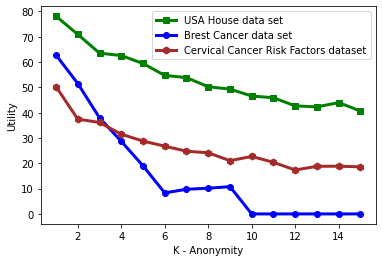

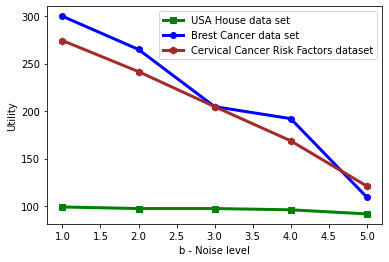

In [ ]:
#Utility
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
acc_k_USAHouse = [78.10670096,70.9331878, 63.53273378, 62.5680729, 59.44148888, 54.71272316, 53.85553688,  
                  50.2521708, 49.31794804, 46.58089632, 45.89382488,42.68701622, 42.28388732, 43.99348328, 40.65998032] #79.7680372563868,
acc_k_brestCancer = [62.7600016466571, 51.5220825866521, 37.9600931189952, 28.6913856598952, 18.9987137593823, 8.30701847025929,
                     9.74101171157336, 10.1395162657666, 10.7727327376636, 1.18053119022442E-06, 0.0000013464719110874, 1.29801594672482E-06,
                     1.53464611165755E-06, 1.21443198875691E-06, 9.65802212736731E-07] #65.4435343623855, 
acc_k_cernivalCancer= [50.2572852340675, 37.4649566384344, 36.1282772023168, 31.4921660939984, 28.7836585416053,
                       26.7728302424121, 24.7620783279058, 24.1628989198529, 21.0291004776595, 22.7283441236621, 20.3848075661027,
                       17.3478270236193, 18.80971323174, 18.8567812568789, 18.595960026054] #48.178427651292, 



plt.plot(k, acc_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='s', markerfacecolor='green', markersize=6, label = "USA House data set") 
plt.plot(k, acc_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, acc_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='h', markerfacecolor='brown', markersize=7, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('Utility') #Accuracy
#plt.title('Utility')
#plt.grid()
plt.legend()
plt.show()

#################################################################################  b

acc_b_USAHouse = [99.01, 97.3720155460385, 97.3598693259741, 96.0494239696362, 91.7034934997089]
acc_b_brestCancer = [299.921040727621, 264.934669383247, 204.69947344229, 192.065635337179, 109.384141016781] #65.4435343623855,
acc_b_cernivalCancer= [274.344136273069, 241.580066853814, 204.703185854001, 168.704375930277, 121.039302997716] #48.6604766080631, 


plt.plot(b, acc_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='s', markerfacecolor='green', markersize=6, label = "USA House data set") 
plt.plot(b, acc_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, acc_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='h', markerfacecolor='brown', markersize=7, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Utility') #Accuracy
#plt.title('Utility')
#plt.grid()
plt.legend()
plt.show()



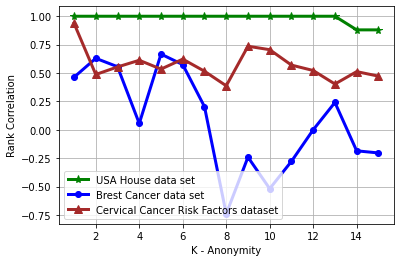

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


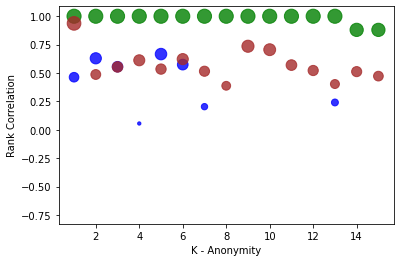

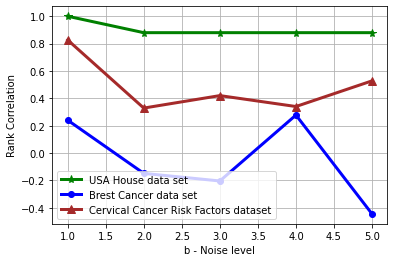

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


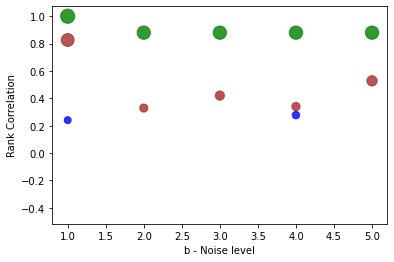

In [ ]:
#rank correlation
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
rank_corr_k_USAHouse = [1, 1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0.88,	0.88]
rank_corr_k_brestCancer = [0.462962963, 0.62962963, 0.555555556, 0.055555556, 0.666666667, 	
                         0.574074074, 0.203703704, -0.740740741, -0.240740741, -0.518518519, 
                        -0.277777778, 0, 0.240740741, -0.185185185, -0.203703704] 
rank_corr_k_cernivalCancer= [0.937298387,	0.487021169,	0.553553427,	0.612147177,	0.534652218,
                           0.622353831,	0.515751008,	0.387600806,	0.735761089,	0.705519153,
                           0.569808468,	0.522177419,	0.403099798,	0.51234879,	0.47265625]


plt.plot(k, rank_corr_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(k, rank_corr_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, rank_corr_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
plt.grid()
plt.legend()
plt.show()


np_pop1 = np.array(rank_corr_k_USAHouse)
np_pop1 = np_pop1 * 100
 
np_pop2 = np.array(rank_corr_k_brestCancer)
np_pop2 = np_pop2 * 100

np_pop3 = np.array(rank_corr_k_cernivalCancer)
np_pop3 = np_pop3 * 100

# Specify c and alpha inside plt.scatter()
plt.scatter(x = k, y = rank_corr_k_USAHouse, s = np.array(np_pop1) * 2, c = 'green', alpha = 0.8)
plt.scatter(x = k, y = rank_corr_k_brestCancer, s = np.array(np_pop2) * 2, c='blue', alpha = 0.8)
plt.scatter(x = k, y = rank_corr_k_cernivalCancer, s = np.array(np_pop3) * 2, c='brown', alpha = 0.8)
plt.xlabel('K - Anonymity')
plt.ylabel('Rank Correlation')
plt.show()
#################################################################################  b

rank_corr_b_USAHouse = [1,	0.88,	0.88,	0.88,	0.88] 
rank_corr_b_brestCancer = [0.240740741,	-0.148148148,	-0.203703704,	0.277777778,	-0.444444444]
rank_corr_b_cernivalCancer= [0.826486895,	0.329007056,	0.420110887,	0.340347782,	0.527847782]


plt.plot(b, rank_corr_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(b, rank_corr_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, rank_corr_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
plt.grid()
plt.legend()
plt.show()

np_pop1 = np.array(rank_corr_b_USAHouse)
np_pop1 = np_pop1 * 100

np_pop2 = np.array(rank_corr_b_brestCancer)
np_pop2 = np_pop2 * 100

np_pop3 = np.array(rank_corr_b_cernivalCancer)
np_pop3 = np_pop3 * 100

# Specify c and alpha inside plt.scatter()
plt.scatter(x = b, y = rank_corr_b_USAHouse, s = np.array(np_pop1) * 2, c = 'green', alpha = 0.8)
plt.scatter(x = b, y = rank_corr_b_brestCancer, s = np.array(np_pop2) * 2, c='blue', alpha = 0.8)
plt.scatter(x = b, y = rank_corr_b_cernivalCancer, s = np.array(np_pop3) * 2, c='brown', alpha = 0.8)
plt.xlabel('b - Noise level')
plt.ylabel('Rank Correlation')
plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


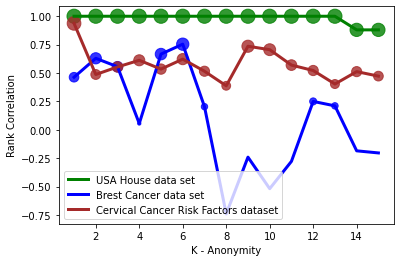

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


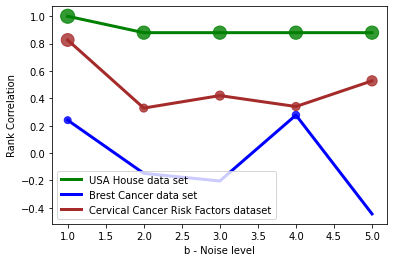

In [ ]:
#rank correlation
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
rank_corr_k_USAHouse = [1, 1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0.88,	0.88]
rank_corr_k_brestCancer = [0.462962963, 0.62962963, 0.555555556, 0.055555556, 0.666666667, 	
                         0.754074074, 0.203703704, -0.740740741, -0.240740741, -0.518518519, 
                         -0.277777778,0.25, 0.210740741, -0.185185185, -0.203703704] 
rank_corr_k_cernivalCancer= [0.937298387,	0.487021169,	0.553553427,	0.612147177,	0.534652218,
                           0.622353831,	0.515751008,	0.387600806,	0.735761089,	0.705519153,
                           0.569808468,	0.522177419,	0.403099798,	0.51234879,	0.47265625]


plt.plot(k, rank_corr_k_USAHouse, color='green', linestyle='solid', linewidth = 3, markerfacecolor='green', markersize=8, label = "USA House data set") #marker='*',
plt.plot(k, rank_corr_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")#marker='o', 
plt.plot(k, rank_corr_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset")#marker='^', 
plt.xlabel('K - Anonymity')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
#plt.grid()
plt.legend()
#plt.show()


np_pop1 = np.array(rank_corr_k_USAHouse)
np_pop1 = np_pop1 * 100
 
np_pop2 = np.array(rank_corr_k_brestCancer)
np_pop2 = np_pop2 * 100

np_pop3 = np.array(rank_corr_k_cernivalCancer)
np_pop3 = np_pop3 * 100

# Specify c and alpha inside plt.scatter()
plt.scatter(x = k, y = rank_corr_k_USAHouse, s = np.array(np_pop1) * 2, c = 'green', alpha = 0.8)
plt.scatter(x = k, y = rank_corr_k_brestCancer, s = np.array(np_pop2) * 2, c='blue', alpha = 0.8)
plt.scatter(x = k, y = rank_corr_k_cernivalCancer, s = np.array(np_pop3) * 2, c='brown', alpha = 0.8)
plt.xlabel('K - Anonymity')
plt.ylabel('Rank Correlation')
plt.show()
#################################################################################  b

rank_corr_b_USAHouse = [1,	0.88,	0.88,	0.88,	0.88] 
rank_corr_b_brestCancer = [0.240740741,	-0.148148148,	-0.203703704,	0.277777778,	-0.444444444]
rank_corr_b_cernivalCancer= [0.826486895,	0.329007056,	0.420110887,	0.340347782,	0.527847782]


plt.plot(b, rank_corr_b_USAHouse, color='green', linestyle='solid', linewidth = 3, markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(b, rank_corr_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, rank_corr_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
#plt.grid()
plt.legend()
#plt.show()

np_pop1 = np.array(rank_corr_b_USAHouse)
np_pop1 = np_pop1 * 100

np_pop2 = np.array(rank_corr_b_brestCancer)
np_pop2 = np_pop2 * 100

np_pop3 = np.array(rank_corr_b_cernivalCancer)
np_pop3 = np_pop3 * 100

# Specify c and alpha inside plt.scatter()
plt.scatter(x = b, y = rank_corr_b_USAHouse, s = np.array(np_pop1) * 2, c = 'green', alpha = 0.8)
plt.scatter(x = b, y = rank_corr_b_brestCancer, s = np.array(np_pop2) * 2, c='blue', alpha = 0.8)
plt.scatter(x = b, y = rank_corr_b_cernivalCancer, s = np.array(np_pop3) * 2, c='brown', alpha = 0.8)
plt.xlabel('b - Noise level')
plt.ylabel('Rank Correlation')
plt.show()

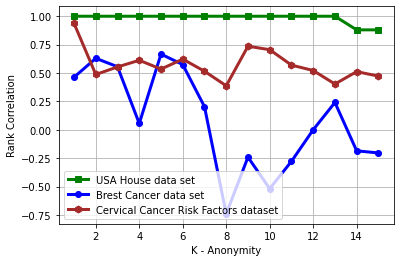

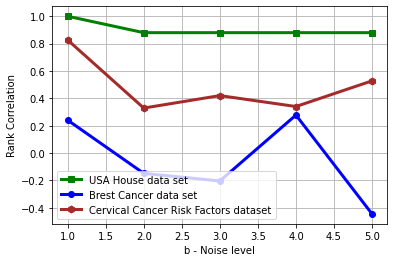

In [ ]:
#rank correlation
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
rank_corr_k_USAHouse = [1, 1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	1,	0.88,	0.88]
rank_corr_k_brestCancer = [0.462962963, 0.62962963, 0.555555556, 0.055555556, 0.666666667, 	
                         0.574074074, 0.203703704, -0.740740741, -0.240740741, -0.518518519, 
                        -0.277777778, 0, 0.240740741, -0.185185185, -0.203703704] 
rank_corr_k_cernivalCancer= [0.937298387,	0.487021169,	0.553553427,	0.612147177,	0.534652218,
                           0.622353831,	0.515751008,	0.387600806,	0.735761089,	0.705519153,
                           0.569808468,	0.522177419,	0.403099798,	0.51234879,	0.47265625]


plt.plot(k, rank_corr_k_USAHouse, color='green', linestyle='solid', linewidth = 3, markerfacecolor='green',marker='s', markersize=6, label = "USA House data set") #
plt.plot(k, rank_corr_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, markerfacecolor='blue',marker='o', markersize=6, label = "Brest Cancer data set")# 
plt.plot(k, rank_corr_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, markerfacecolor='brown',marker='h', markersize=7, label = "Cervical Cancer Risk Factors dataset")# 
plt.xlabel('K - Anonymity')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
plt.grid()
plt.legend()
plt.show()


#################################################################################  b

rank_corr_b_USAHouse = [1,	0.88,	0.88,	0.88,	0.88] 
rank_corr_b_brestCancer = [0.240740741,	-0.148148148,	-0.203703704,	0.277777778,	-0.444444444]
rank_corr_b_cernivalCancer= [0.826486895,	0.329007056,	0.420110887,	0.340347782,	0.527847782]


plt.plot(b, rank_corr_b_USAHouse, color='green', linestyle='solid', linewidth = 3, markerfacecolor='green',marker='s', markersize=6, label = "USA House data set") 
plt.plot(b, rank_corr_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, markerfacecolor='blue',marker='o', markersize=6, label = "Brest Cancer data set")
plt.plot(b, rank_corr_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, markerfacecolor='brown',marker='h', markersize=7, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Rank Correlation') 
#plt.title('Rank Correlation')
plt.grid()
plt.legend()
plt.show()


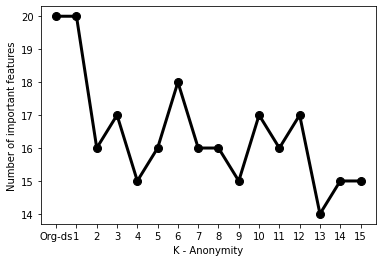

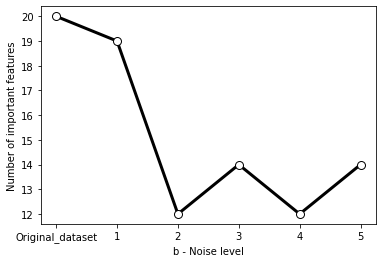

In [ ]:
#Priority Rate of Features (Important order) _Cervical cancer
import matplotlib.pyplot as plt
b = ['Original_dataset', 1, 2, 3, 4, 5]
PriorityRate_b = [20,	19,	12,	14,	12,	14]
k = ['Org-ds', 1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
PriorityRate_k = [20, 20,	16,	17,	15,	16,	18,	16,	16,	15,	17,	16,	17,	14,	15,	15]

plt.plot(k, PriorityRate_k, color='black', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)#markerfacecolor='g',
plt.xlabel('K - Anonymity')
plt.ylabel('Number of important features') 
#plt.title('Number of important features')
#plt.grid()
plt.show()

plt.plot(b, PriorityRate_b, color='black', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)#
plt.xlabel('b - Noise level')
plt.ylabel('Number of important features') 
#plt.title('Number of important features')
#plt.grid()
plt.show()

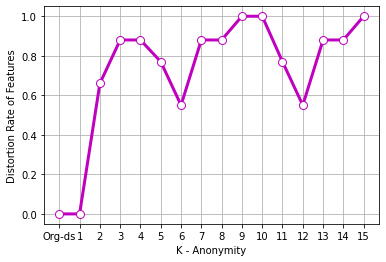

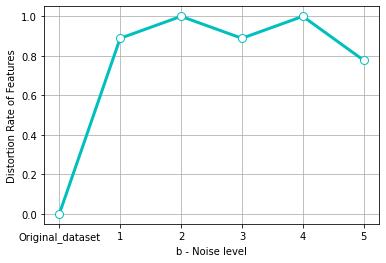

In [ ]:
#Priority Rate of Features _Brest Cancer
import matplotlib.pyplot as plt
b = ['Original_dataset', 1, 2, 3, 4, 5]
PriorityRate_b = [0, 0.888888, 1, 0.888888, 1, 0.777777]
k = ['Org-ds', 1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
PriorityRate_k = [0, 0, 0.66, 0.88, 0.88, 0.77, 0.55, 0.88, 0.88, 1, 1, 0.77, 0.55, 0.88, 0.88, 1]

plt.plot(k, PriorityRate_k, color='m', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('K - Anonymity')
plt.ylabel('Distortion Rate of Features') 
#plt.title('Rank Correlation')
plt.grid()
plt.show()

plt.plot(b, PriorityRate_b, color='c', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('b - Noise level')
plt.ylabel('Distortion Rate of Features') 
#plt.title('Rank Correlation')
plt.grid()
plt.show()


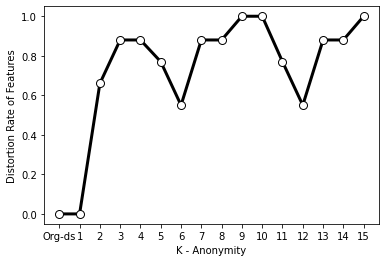

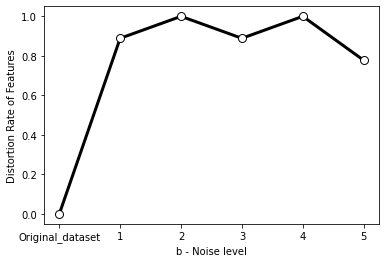

In [ ]:
#new
#Priority Rate of Features _Brest Cancer
import matplotlib.pyplot as plt
b = ['Original_dataset', 1, 2, 3, 4, 5]
PriorityRate_b = [0, 0.888888, 1, 0.888888, 1, 0.777777]
k = ['Org-ds', 1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
PriorityRate_k = [0, 0, 0.66, 0.88, 0.88, 0.77, 0.55, 0.88, 0.88, 1, 1, 0.77, 0.55, 0.88, 0.88, 1] #

plt.plot(k, PriorityRate_k, color='black', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('K - Anonymity')
plt.ylabel('Distortion Rate of Features') 
#plt.title('Rank Correlation')
#plt.grid()
plt.show()

plt.plot(b, PriorityRate_b, color='black', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('b - Noise level')
plt.ylabel('Distortion Rate of Features') 
#plt.title('Rank Correlation')
#plt.grid()
plt.show()

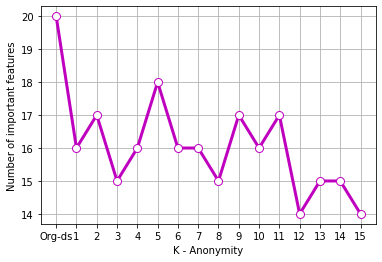

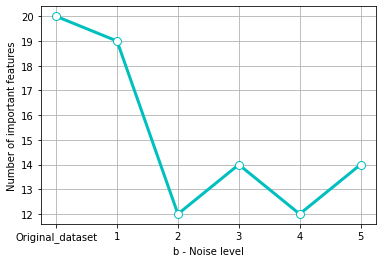

In [ ]:
#Priority Rate of Features _ Cervical Cancer
import matplotlib.pyplot as plt
b = ['Original_dataset', 1, 2, 3, 4, 5]
PriorityRate_b = [20,	19,	12,	14,	12,	14]
k = ['Org-ds', 1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
PriorityRate_k = [20,	16,	17,	15,	16,	18,	16,	16,	15,	17,	16,	17,	14,	15,	15,	14]

plt.plot(k, PriorityRate_k, color='m', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('K - Anonymity')
plt.ylabel('Number of important features') 
#plt.title('Rank Correlation')
plt.grid()
plt.show()

plt.plot(b, PriorityRate_b, color='c', linestyle='solid', marker='o', linewidth = 3, markerfacecolor='w', markersize=8)
plt.xlabel('b - Noise level')
plt.ylabel('Number of important features') 
#plt.title('Rank Correlation')
plt.grid()
plt.show()

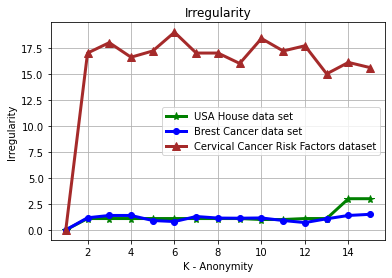

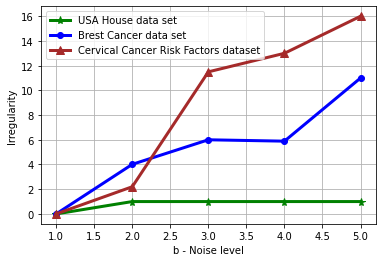

In [ ]:
#Irregularity OR Entropy
#Utility
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
acc_k_USAHouse = [0,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	
                  1.09375, 1.09375,	1,	1,	1.09375,	1.09375,	3,	3]
acc_k_brestCancer = [0,	1.166666667,	1.388888889,	1.388888889,	0.902777778,	0.805555556,	1.288888889,
                     1.138888889,	1.125,	1.15,	0.902777778,	0.705555556,	1.068888889,	1.388888889,	1.5]
acc_k_cernivalCancer= [0, 17,	18,	16.6,	17.2,	19,	17,	17,	16,	18.4,	17.2,	17.7,	15,	16.1,	15.6]

plt.plot(k, acc_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(k, acc_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, acc_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('Irregularity') #Accuracy
plt.title('Irregularity')
plt.grid()
plt.legend()
plt.show()

#################################################################################  b

acc_b_USAHouse = [0, 1, 1, 1, 1] 
acc_b_brestCancer = [0, 4.0138, 6, 5.8888, 11]
acc_b_cernivalCancer= [0, 2.2, 11.5, 13, 16]


plt.plot(b, acc_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(b, acc_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, acc_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Irregularity') #Accuracy
#plt.title('Irregularity')
plt.grid()
plt.legend()
plt.show()

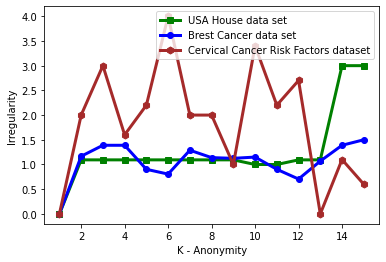

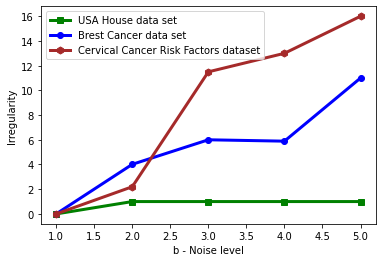

In [ ]:
#new Dec2021
#Irregularity OR Entropy
#Utility
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
acc_k_USAHouse = [0,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	
                  1.09375, 1.09375,	1,	1,	1.09375,	1.09375,	3,	3]
acc_k_brestCancer = [0,	1.166666667,	1.388888889,	1.388888889,	0.902777778,	0.805555556,	1.288888889,
                     1.138888889,	1.125,	1.15,	0.902777778,	0.705555556,	1.068888889,	1.388888889,	1.5]
acc_k_cernivalCancer= [0, 17-15,	18-15,	16.6-15,	17.2-15,	19-15,	17-15,	17-15,	16-15,	18.4-15,	17.2-15,	17.7-15,	15-15,	16.1-15,	15.6-15]

plt.plot(k, acc_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='s', markerfacecolor='green', markersize=6, label = "USA House data set") 
plt.plot(k, acc_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, acc_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='h', markerfacecolor='brown', markersize=7, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('Irregularity') #Accuracy
#plt.title('Irregularity')
#plt.grid()
plt.legend()
plt.show()

#################################################################################  b

acc_b_USAHouse = [0, 1, 1, 1, 1] 
acc_b_brestCancer = [0, 4.0138, 6, 5.8888, 11]
acc_b_cernivalCancer= [0, 2.2, 11.5, 13, 16]


plt.plot(b, acc_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='s', markerfacecolor='green', markersize=6, label = "USA House data set") 
plt.plot(b, acc_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, acc_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='h', markerfacecolor='brown', markersize=7, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('Irregularity') #Accuracy
#plt.title('Irregularity')
#plt.grid()
plt.legend()
plt.show()

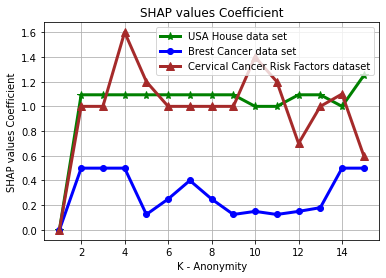

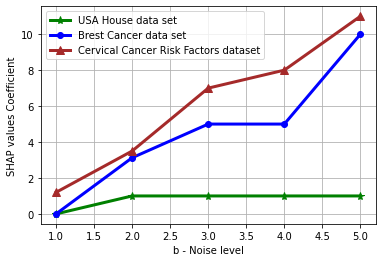

In [ ]:
#Irregularity OR Entropy
#Second part (SHAP values' Coefficient)
import numpy as np
import matplotlib.pyplot as plt


k = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]) #'Original data'
b = np.array([1, 2, 3, 4, 5])
#################################################################################  K
acc_k_USAHouse = [0,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,	1.09375,
                	1,	1,	1.09375,	1.09375,	1,	1.25]
acc_k_brestCancer = [0,	0.5,	0.5,	0.5,	0.125,	0.25,	0.4,	0.25,	0.125,	0.15,	0.125,	0.15,	0.18,	0.5,	0.5]
acc_k_cernivalCancer= [0,	1,	1,	1.6,	1.2,	1,	1,	1,	1,	1.4,	1.2,	0.7,	1,	1.1,	0.6	]

plt.plot(k, acc_k_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(k, acc_k_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(k, acc_k_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('K - Anonymity')
plt.ylabel('SHAP values Coefficient') #Accuracy
plt.title('SHAP values Coefficient')
plt.grid()
plt.legend()
plt.show()

#################################################################################  b

acc_b_USAHouse = [0,	1,	1,	1,	1]
acc_b_brestCancer = [0,	3.125,	5,	5,	10]
acc_b_cernivalCancer= [1.2,	3.5,	7,	8,	11]


plt.plot(b, acc_b_USAHouse, color='green', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='green', markersize=8, label = "USA House data set") 
plt.plot(b, acc_b_brestCancer, color='blue', linestyle='solid', linewidth = 3, marker='o', markerfacecolor='blue', markersize=6, label = "Brest Cancer data set")
plt.plot(b, acc_b_cernivalCancer, color='brown', linestyle='solid', linewidth = 3, marker='^', markerfacecolor='brown', markersize=8, label = "Cervical Cancer Risk Factors dataset") 
plt.xlabel('b - Noise level')
plt.ylabel('SHAP values Coefficient') #Accuracy
#plt.title('SHAP values Coefficient')
plt.grid()
plt.legend()
plt.show()